Perform Imports

In [1]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas
from scipy.signal import butter, lfilter, freqz
from mpl_toolkits.mplot3d import Axes3D
from fastdtw import fastdtw, dtw
from pprint import pprint
from scipy.spatial.distance import euclidean, cityblock


Array for easily mapping joint IDs to joint names

In [2]:
JOINT_MAPPINGS = [
    "Ass",
    "Middle of the spine",
    "Neck",
    "Head",
    "Left Shoulder",
    "Left Elbow",
    "Left Wrist",
    "Left Hand",
    "Right Shoulder",
    "Right Elbow",
    "Right Wrist",
    "Right Hand",
    "Left Hip",
    "Left Knee",
    "Left Ankle",
    "Left Foot",
    "Right Hip",
    "Right Knee",
    "Right Ankle",
    "Right Foot",
    "Spine at the Shoulder"
]

Pair of functions from stack overflow to perform lowpass filtering. 

https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
# Filter specifications.
ORDER = 2
SAMPLE_RATE = 20.0      # sample rate in Hz
CUTOFF_F = 2.0  # cutoff frequency in Hz

In [5]:
def discrete_derivative(x,sample_rate=SAMPLE_RATE):
    derivative = np.array([x[i] - x[i-1] for i in range(1,len(x))])
    derivative = derivative*sample_rate
    return derivative

In [6]:
TEMPLATE_FILE = open('lifts/Chris_Single_Squat_1.json')
MATCHING_FILE = open('lifts/Chris_Single_Squat_2.json')

template_data = json.load(TEMPLATE_FILE)
data = json.load(MATCHING_FILE)

In [7]:
template_frames =  template_data["Details"]["BodyData"]["Details"]["OrderedFrames"]
frames =  data["Details"]["BodyData"]["Details"]["OrderedFrames"]

Get data for the height of the lower spine

In [8]:
template_ls_height = np.array([joint["Details"]["Joints"][0]['Y'] for joint in template_frames])[10:-3]
ls_height = np.array([joint["Details"]["Joints"][0]['Y'] for joint in frames])

# Comparison between template and matching data.

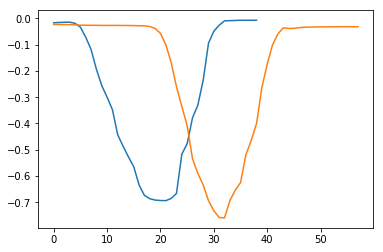

In [9]:
plt.plot(template_ls_height)
plt.plot(ls_height)

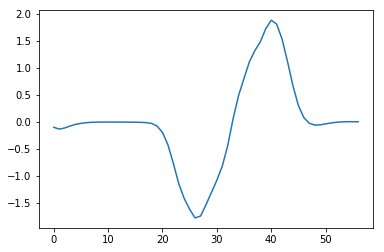

In [10]:
ls_height_filtered = butter_lowpass_filter(ls_height,CUTOFF_F,SAMPLE_RATE,ORDER)
plt.plot(discrete_derivative(ls_height_filtered))

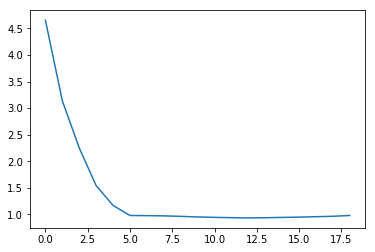

In [11]:
distances = []
for offset in range(len(ls_height)-len(template_ls_height)):
    distance, _ = fastdtw(template_ls_height, ls_height[offset:len(template_ls_height)+offset], radius = 1, dist=euclidean)
    distances = distances + [distance]
distances = np.array(distances)
plt.plot(distances)

In [12]:
from scipy.signal import argrelextrema
minInd = argrelextrema(distances, np.less, order=5, mode="wrap")
minInd

(array([12], dtype=int32),)

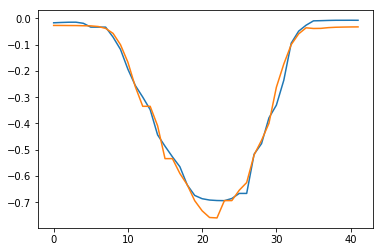

In [13]:
o = minInd[0][0]
distance, path = dtw(template_ls_height, ls_height[o:len(template_ls_height)+o], dist=euclidean)
warped_t = np.array([template_ls_height[x[0]] for x in path])
warped = np.array([ls_height[o:len(template_ls_height)+o][x[1]] for x in path])
plt.plot(warped_t)
plt.plot(warped)